## TPE Tuning

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

In [58]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [59]:
group_one = dataset[dataset["Diagnosis"] == 0]
group_two = dataset[dataset["Diagnosis"] == 3]

combined_group_two = pd.concat([group_one, group_two], ignore_index = True)
combined_group_two["Diagnosis"].unique()

array([0, 3])

In [60]:
combined_group_two

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
1,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
2,14,1,78.6137,0,29.0,0.12,188.33,0.49,183.76,39.63,...,241.64,0.44,226.48,35.11,664.29,3.10,8478.33,3.01,1809.0,3292.0
3,15,0,80.9068,0,29.0,0.10,161.28,0.54,174.53,35.94,...,221.76,0.45,NaN,30.57,NaN,3.12,4287.78,2.90,2188.0,3603.0
4,16,0,65.5205,0,28.0,0.12,166.97,0.58,202.96,38.42,...,228.53,0.50,228.72,28.98,686.36,2.90,-1381.99,2.73,1829.0,3695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1201,1,75.6411,3,26.0,0.18,173.84,0.59,215.04,33.84,...,281.15,0.37,222.73,27.94,609.75,2.84,-1924.49,1.94,1112.0,2705.0
320,1221,0,71.2712,3,21.0,0.22,174.02,0.58,211.07,30.56,...,224.78,0.47,205.49,27.36,597.20,2.77,1146.39,2.44,1526.0,2913.0
321,1248,1,79.8548,3,23.0,0.19,199.31,0.56,229.63,33.13,...,220.41,0.48,214.97,27.16,639.47,2.79,-919.84,1.99,1215.0,2273.0
322,1253,1,62.7452,3,24.0,0.05,142.05,0.50,147.12,46.21,...,217.38,0.51,220.55,32.54,664.84,3.09,5289.89,3.27,2321.0,3739.0


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_group_two.drop("Diagnosis", axis=1),  
    combined_group_two["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((226, 23), (98, 23))

In [62]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_bayes.fit(X_train)
X_train_bayes = imputer_bayes.transform(X_train)
X_test_bayes = imputer_bayes.transform(X_test)

In [63]:
X_train_bayes_t = pd.DataFrame(
    X_train_bayes, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_bayes_t = pd.DataFrame(
    X_test_bayes, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [64]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_bayes_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [65]:
X_train_t = pipe.transform(X_train_bayes_t)
X_test_t = pipe.transform(X_test_bayes_t)

X_train_t.shape, X_test_t.shape

((226, 23), (98, 23))

In [66]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	6
Rejected: 	9
Iteration:

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x1FC48F93340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1FC48F93340, verbose=2)

In [67]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['Ageatscreening', 'MMSE0m', 'ERCsContrastbaseline',
       'ERCsCorelationbaseline', 'ERCsSumVariancebaseline',
       'ERCsEntropybaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [68]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((226, 9), (98, 9))

## TPE

In [69]:
from sklearn.preprocessing import LabelEncoder

# 1) Fit a label encoder on the training labels:
le_train = LabelEncoder().fit(y_train)
le_test = LabelEncoder().fit(y_test)

# 2) Transform y_train (and later y_test) to {0,1} internally:
y_train_enc = le_train.transform(y_train)
y_test_enc = le_test.transform(y_test)

In [70]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
            
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 200, 500)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 3)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.2)
    xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 0.8)
    xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 0.8)
    xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 6)
    xgb_gamma = trial.suggest_float("xgb_gamma", 0.0, 2.0)

    model = XGBClassifier(
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        min_child_weight=xgb_min_child_weight,
        gamma=xgb_gamma,
        eval_metric="logloss",
        use_label_encoder=False,
        objective="binary:logistic",
        verbosity=0
    )

    score = cross_val_score(model, X_train_t, y_train_enc, scoring="accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [71]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=10)

[I 2025-05-13 21:00:04,520] A new study created in memory with name: no-name-7a0318c9-c008-4dfc-92b7-9435dd7b2206
[I 2025-05-13 21:00:08,536] Trial 0 finished with value: 0.9733201581027668 and parameters: {'xgb_n_estimators': 419, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.010570327710650527, 'xgb_subsample': 0.7456599259646782, 'xgb_colsample_bytree': 0.7722877910487728, 'xgb_min_child_weight': 5, 'xgb_gamma': 1.5543897232349353}. Best is trial 0 with value: 0.9733201581027668.
[I 2025-05-13 21:00:09,980] Trial 1 finished with value: 0.9733201581027668 and parameters: {'xgb_n_estimators': 241, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.07993474986080377, 'xgb_subsample': 0.6016981229971905, 'xgb_colsample_bytree': 0.6903727645880436, 'xgb_min_child_weight': 5, 'xgb_gamma': 1.5328615541357709}. Best is trial 0 with value: 0.9733201581027668.
[I 2025-05-13 21:00:12,515] Trial 2 finished with value: 0.9687747035573123 and parameters: {'xgb_n_estimators': 431, 'xgb_max_depth': 2, 'xgb_le

In [72]:
study.best_params

{'xgb_n_estimators': 419,
 'xgb_max_depth': 2,
 'xgb_learning_rate': 0.010570327710650527,
 'xgb_subsample': 0.7456599259646782,
 'xgb_colsample_bytree': 0.7722877910487728,
 'xgb_min_child_weight': 5,
 'xgb_gamma': 1.5543897232349353}

In [73]:
study.best_value

0.9733201581027668

In [74]:
r = study.trials_dataframe()
r.head()

,number,value,datetime_start,datetime_complete,duration,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_subsample,state
0,0,0.973320,2025-05-13 21:00:04.581729,2025-05-13 21:00:08.536374,0 days 00:00:03.954645,0.772288,1.554390,0.010570,2,5,419,0.745660,COMPLETE
1,1,0.973320,2025-05-13 21:00:08.544972,2025-05-13 21:00:09.980915,0 days 00:00:01.435943,0.690373,1.532862,0.079935,2,5,241,0.601698,COMPLETE
2,2,0.968775,2025-05-13 21:00:09.980915,2025-05-13 21:00:12.515326,0 days 00:00:02.534411,0.675233,0.240974,0.137615,2,2,431,0.634183,COMPLETE
3,3,0.973320,2025-05-13 21:00:12.526583,2025-05-13 21:00:15.233279,0 days 00:00:02.706696,0.778226,1.775469,0.120610,2,2,477,0.733378,COMPLETE
4,4,0.973320,2025-05-13 21:00:15.233279,2025-05-13 21:00:17.021985,0 days 00:00:01.788706,0.633857,1.732625,0.076833,2,2,273,0.657952,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_11600\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


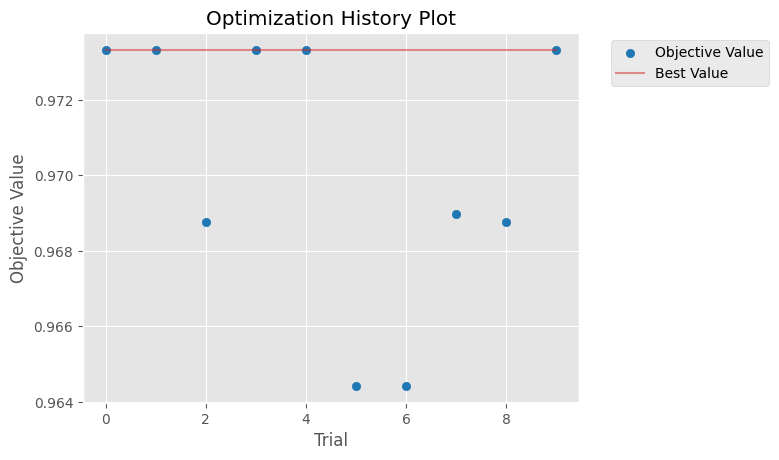

In [75]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11600\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

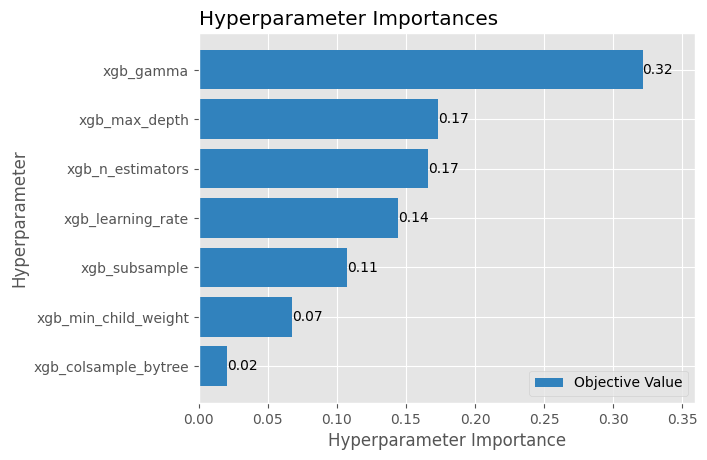

In [76]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_11600\1403512554.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='xgb_colsample_bytree', ylabel='Objective Value'>,
       <Axes: xlabel='xgb_gamma'>, <Axes: xlabel='xgb_learning_rate'>,
       <Axes: xlabel='xgb_max_depth'>,
       <Axes: xlabel='xgb_min_child_weight'>,
       <Axes: xlabel='xgb_n_estimators'>, <Axes: xlabel='xgb_subsample'>],
      dtype=object)

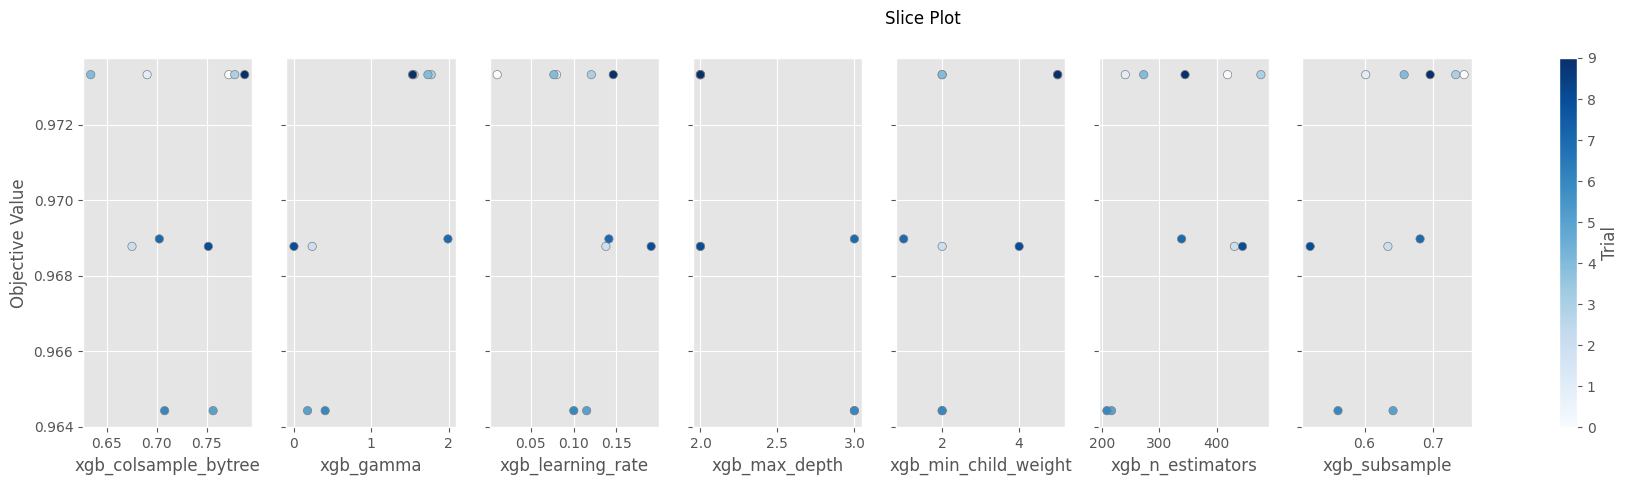

In [77]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["xgb_n_estimators", "xgb_max_depth", "xgb_learning_rate", 
            'xgb_subsample', 'xgb_colsample_bytree', 'xgb_min_child_weight',
            'xgb_gamma'],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_11600\2601326980.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

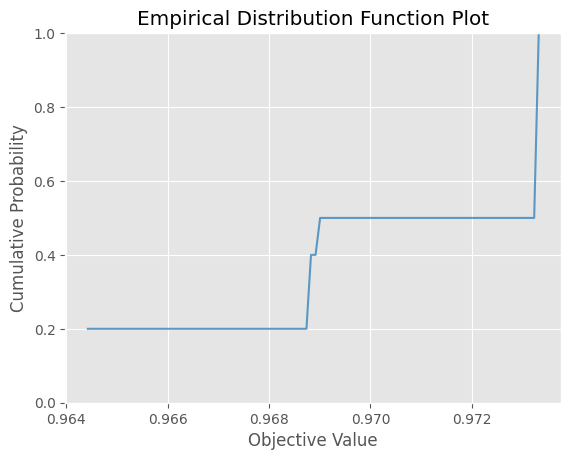

In [78]:
optuna.visualization.matplotlib.plot_edf([study])

## Classification

In [79]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = XGBClassifier(
                n_estimators=study.best_params["xgb_n_estimators"],
                max_depth=study.best_params["xgb_max_depth"],
                learning_rate=study.best_params["xgb_learning_rate"],
                subsample=study.best_params["xgb_subsample"],
                colsample_bytree=study.best_params["xgb_colsample_bytree"],
                min_child_weight=study.best_params["xgb_min_child_weight"],
                gamma=study.best_params["xgb_gamma"],
                objective="binary:logistic",
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [80]:
trained_xgb_n, metrics_xgb_n = run_model("XGBoost", "Complete", X_train_bayes_t, y_train_enc)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", "Boruta", X_train_t, y_train_enc)

In [81]:
validation_df = pd.concat([metrics_xgb_n, metrics_xgb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
XGBoost    balanced_accuracy Complete          0.357    23                   0.979   
                             Boruta            0.282    9                    0.980   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          0.357    23                  0.003   
                             Boruta            0.282    9                   0.002   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
XGBoost    balanced_accuracy Complete          0.357    23                  0.970   
                             Boruta            0.282    9                   0.974   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
XGBoost    balanced_accuracy Complete          0.357    23                 0.032  
                             Boruta            0.282    9                  0.033

In [82]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train), 3),
                "recall": round(recall_score(y_train, pred_train), 3),
                "f1": round(f1_score(y_train, pred_train), 3),
                "roc_auc_ovr": round(roc_auc_score(y_train, pred_train_proba[:, 1]),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test), 3),
                "recall": round(recall_score(y_test, pred_test), 3),
                "f1": round(f1_score(y_test, pred_test), 3),
                "roc_auc_ovr": round(roc_auc_score(y_test, pred_test_proba[:, 1]), 3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [83]:
results = "all"
prediction_df_report = None

if results == "all":
    
    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_bayes_t, X_test_bayes_t, y_train_enc, y_test_enc)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    prediction_df = pd.concat([pred_xgb_n, pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train_enc, y_test_enc)
    
    prediction_df = pd.concat([pred_xgb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                          
Boruta            XGBoost    0.109               23             accuracy                0.978   
                                                                balanced_accuracy       0.980   
                                                                precision               0.957   
                                                                recall                  0.989   
                                                                f1                      0.973   
                                                                roc_auc_ovr             0.999   
                             0.083               9              accuracy                0.978   
                                                                balanced_accuracy       0.980   
                                                                precision               0.957   
                                                                recall                  0.989   
                                                                f1                      0.973   
                                                                roc_auc_ovr             0.998   

                                                                                   Test data  
Feature Selection Classifier Classification Time Total Features Metric                        
Boruta            XGBoost    0.109               23             accuracy               0.980  
                                                                balanced_accuracy      0.983  
                                                                precision              0.951  
                                                                recall                 1.000  
                                                                f1                     0.975  
                                                                roc_auc_ovr            0.994  
                             0.083               9              accuracy               0.980  
                                                                balanced_accuracy      0.983  
                                                                precision              0.951  
                                                                recall                 1.000  
                                                                f1                     0.975  
                                                                roc_auc_ovr            0.993

### Export model

In [84]:
import pickle

# Save the trained model using pickle
with open("xgboost_model_group_two.pkl", "wb") as file:
    pickle.dump(trained_xgb_t, file)

print("XGBppst model saved successfully!")

XGBppst model saved successfully!
